In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
from analysis import *

In [2]:
Lx, Lt = 16, 48
V = (Lx ** 3) * Lt
set_dimensions(Lx, Lt)

(16, 48, 196608, [16, 16, 16, 48])

In [3]:
# psub = subset of sink momenta to graph
# props_sub = subset of propagators to use (number of graphs to show)
# label = if True, will label each point with its momenta
# def graph_subset(ksub, psub, props_sub, ms = True, label = False):
def graph_subset(indices, ms = True, label = False):
    f, ax = plt.subplots()
    p_squared_sub = p_squared[indices]
    if ms:
        Zsub = Z_MSbar_avg[indices]
    else:
        Zsub = Z_avg[indices]
    σsub = σ[indices]
    ax.errorbar(p_squared_sub, np.real(Zsub), yerr = np.abs(σsub), fmt = 'o')
    if label:
        for i, ii in enumerate(indices):
            ax.annotate(k_list[ii], (p_squared_sub[i], np.real(Zsub[i])))
    ax.set_xlabel('$p^2$')
    ax.set_ylabel('$\mathcal{Z}(p^2)$')
    ax.set_title('Subset of momenta')
    plt.tight_layout()
    plt.show()
def graph_subset_error(psub, props_sub, label = False):
    num_subplots = (int(np.ceil(len(props_sub) / 2)), 2)
    f, ax = plt.subplots(num_subplots[0], num_subplots[1], figsize = (10, 10))
    ax = ax.flatten()
    p_squared_sub = np.array([np.abs(analysis.square(p)) for p in psub])
    for idx, mom in enumerate(props_sub):
        rsquaredsub = [analysis.square(np.array(p) - np.array(mom)) for p in psub]
        σsub = np.array([σ[idx][analysis.plist_to_string(p)] for p in psub])
        ax[idx].scatter(rsquaredsub, σsub)
        if label:
            for i, r in enumerate(rsquaredsub):
                ax[idx].annotate(psub[i], (r, σsub[i]))
        ax[idx].set_xlabel('$|p - p_{prop}|^2$')
        ax[idx].set_ylabel('Error')
        ax[idx].set_title('Prop momentum = ' + str(prop_list[idx]))
    plt.tight_layout()
    plt.show()

## Test current analysis

In [ ]:
cfgbase = 'cl3_16_48_b6p1_m0p2450'
# job_num = 28337
job_num = 28357
data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/meas/' + cfgbase + '_' + str(job_num)
cfgs = []
for (dirpath, dirnames, file) in os.walk(data_dir):
    cfgs.extend(file)
for idx, cfg in enumerate(cfgs):
    cfgs[idx] = data_dir + '/' + cfgs[idx]
n_cfgs = len(cfgs)
q = [3, 3, 0, 0]
q_lat = np.sin(to_linear_momentum(q))
k1, k2, props_k1, props_k2, props_q, GV, GA, GO = readfiles(cfgs, q, False)

In [ ]:
props_k1_b, props_k2_b, props_q_b = bootstrap(props_k1), bootstrap(props_k2), bootstrap(props_q)
GV_boot, GA_boot = np.array([bootstrap(GV[mu]) for mu in range(4)]), np.array([bootstrap(GA[mu]) for mu in range(4)])
props_k1_inv, props_k2_inv, props_q_inv = invert_props(props_k1_b), invert_props(props_k2_b), invert_props(props_q_b)

In [ ]:
Zq = quark_renorm(props_q_inv, q_lat)
qlat_slash = slash(q_lat)

In [ ]:
GammaV, GammaA = np.zeros(GV_boot.shape, dtype = np.complex64), np.zeros(GA_boot.shape, dtype = np.complex64)
qDotV, qDotA = np.zeros(GV_boot.shape[1:]), np.zeros(GA_boot.shape[1:])
for mu in range(4):
    GammaV[mu], GammaA[mu] = amputate_threepoint(props_k2_inv, props_k1_inv, GV_boot[mu]), amputate_threepoint(props_k2_inv, props_k1_inv, GA_boot[mu])
    qDotV, qDotA = qDotV + q_lat[mu] * GammaV[mu], qDotA + q_lat[mu] * GammaA[mu]
    ZV = 12 * Zq * square(q_lat) / np.einsum('zaiaj,ji->z', qDotV, qlat_slash)
    ZA = 12 * Zq * square(q_lat) / np.einsum('zaiaj,jk,ki->z', qDotA, gamma5, qlat_slash)

In [ ]:
GammaV[0, 0]

In [ ]:
props_k1_b.shape

In [ ]:
props_k1_inv[0][0, :, 0, :]

In [ ]:
props_q_inv[0][0, :, 0, :]

In [ ]:
k_list

## Test with no momentum insertion

In [10]:
# job_num = 28357
# file = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/currents' + str(job_num) + '/Z.h5'
job_num = 28390
file = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/currents' + str(job_num) + '/Z_momfrac.h5'
f = h5py.File(file, 'r')

Zq = f['Zq'][()]
k_list = f['momenta'][()]
p_squared = np.array([np.abs(square(to_linear_momentum(k))) for k in k_list])

ZV = f['ZV'][()]
ZA = f['ZA'][()]

ZV_μ = np.mean(ZV, axis = 1)
ZV_σ = np.std(ZV, axis = 1)
ZA_μ = np.mean(ZA, axis = 1)
ZA_σ = np.std(ZA, axis = 1)
Zq_μ = np.mean(Zq, axis = 1)
Zq_σ = np.std(Zq, axis = 1)

<IPython.core.display.Javascript object>


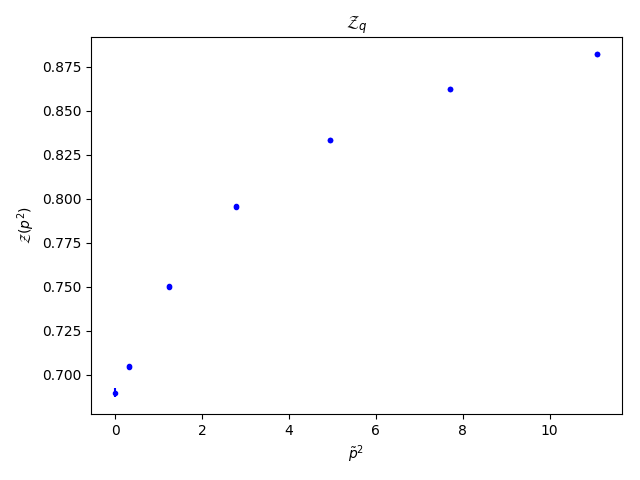

In [11]:
plt.figure()

plt.errorbar(p_squared, np.real(Zq_μ), yerr = np.real(Zq_σ), fmt = '.', c = 'b')
plt.title('$\\mathcal{Z}_q$')
plt.xlabel('$\\tilde{p}^2$')
plt.ylabel('$\\mathcal{Z}(p^2)$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


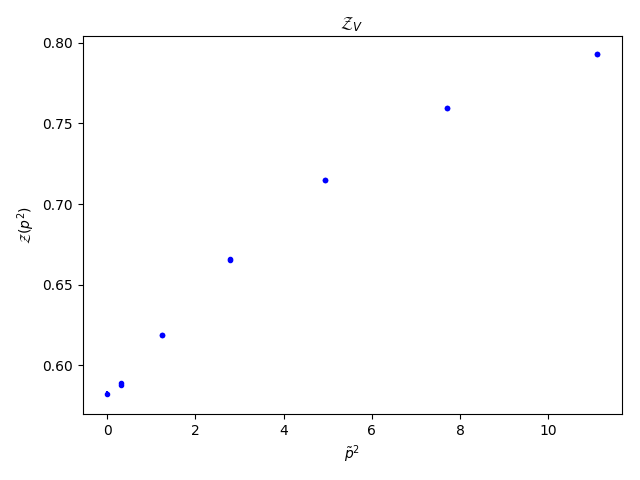

In [12]:
plt.figure()

plt.errorbar(p_squared, np.real(ZV_μ), yerr = np.real(ZV_σ), fmt = '.', c = 'b')
plt.title('$\\mathcal{Z}_V$')
plt.xlabel('$\\tilde{p}^2$')
plt.ylabel('$\\mathcal{Z}(p^2)$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


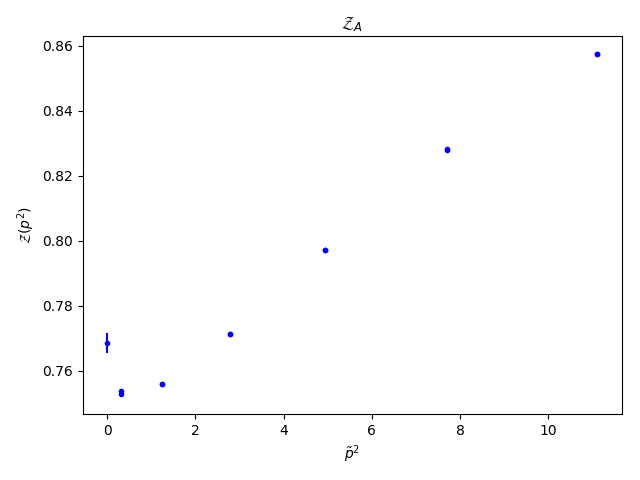

In [13]:
plt.figure()

plt.errorbar(p_squared, np.real(ZA_μ), yerr = np.real(ZA_σ), fmt = '.', c = 'b')
plt.title('$\\mathcal{Z}_A$')
plt.xlabel('$\\tilde{p}^2$')
plt.ylabel('$\\mathcal{Z}(p^2)$')

plt.tight_layout()
plt.show()

## Run current renormalization

In [14]:
job_num = 28357
file = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/currents' + str(job_num) + '/Z.h5'
f = h5py.File(file, 'r')

Zq = f['Zq'][()]
k_list = f['momenta'][()]
p_squared = np.array([np.abs(square(to_linear_momentum(k))) for k in k_list])

ZV = f['ZV'][()]
ZA = f['ZA'][()]

ZV_μ = np.mean(ZV, axis = 1)
ZV_σ = np.std(ZV, axis = 1)
ZA_μ = np.mean(ZA, axis = 1)
ZA_σ = np.std(ZA, axis = 1)
Zq_μ = np.mean(Zq, axis = 1)
Zq_σ = np.std(Zq, axis = 1)

<IPython.core.display.Javascript object>


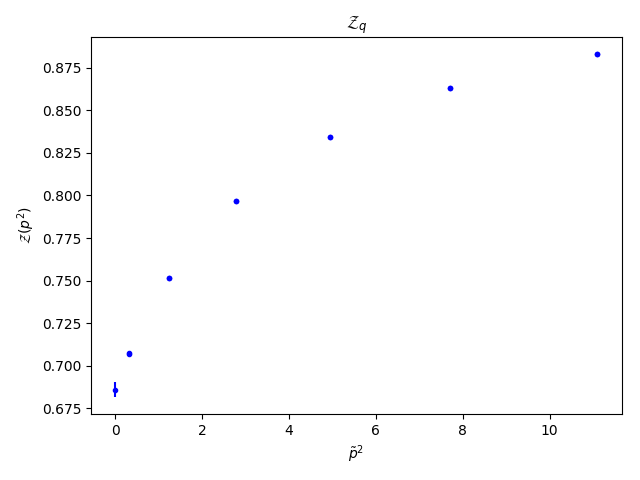

In [15]:
plt.figure()

plt.errorbar(p_squared, np.real(Zq_μ), yerr = np.real(Zq_σ), fmt = '.', c = 'b')
plt.title('$\\mathcal{Z}_q$')
plt.xlabel('$\\tilde{p}^2$')
plt.ylabel('$\\mathcal{Z}(p^2)$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


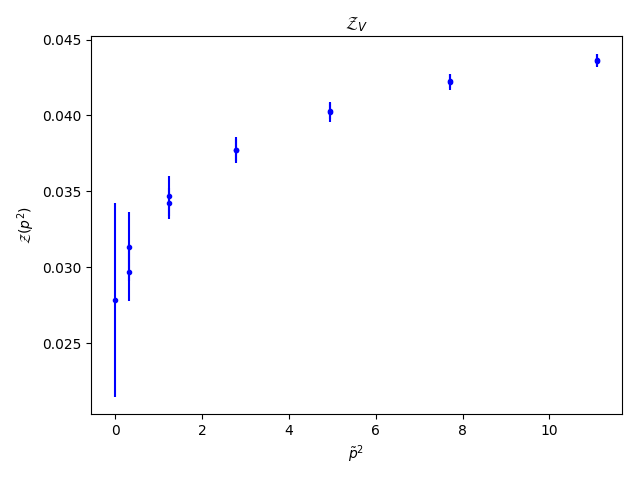

In [16]:
plt.figure()

plt.errorbar(p_squared, np.real(ZV_μ), yerr = np.real(ZV_σ), fmt = '.', c = 'b')
plt.title('$\\mathcal{Z}_V$')
plt.xlabel('$\\tilde{p}^2$')
plt.ylabel('$\\mathcal{Z}(p^2)$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


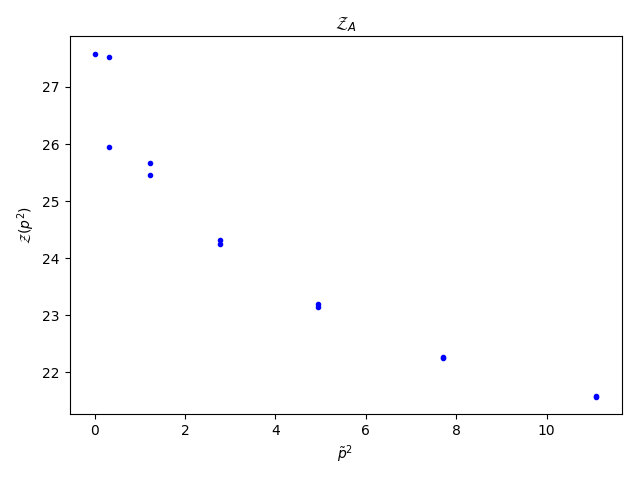

In [18]:
plt.figure()

plt.errorbar(p_squared, 1 / np.real(ZA_μ), yerr = np.real(ZA_σ), fmt = '.', c = 'b')
plt.title('$\\mathcal{Z}_A$')
plt.xlabel('$\\tilde{p}^2$')
plt.ylabel('$\\mathcal{Z}(p^2)$')

plt.tight_layout()
plt.show()

## Convert to MSbar

In [ ]:
nl = 3
frat = h5py.File('/Users/theoares/Dropbox (MIT)/research/npr_momfrac/RIMOM_MSbar_conversion_ratios/ratios_24_24_ptwid_l' + str(nl) + '_Ap145.h5', 'r')
fqrat = h5py.File('/Users/theoares/Dropbox (MIT)/research/npr_momfrac/RIMOM_MSbar_conversion_ratios/Zqratios_24_24_ptwid_l' + str(nl) + '_Ap145.h5', 'r')
k_rat = frat['momenta'][()]
ratios = frat['ratios'][()]
qratios = fqrat['ratios'][()]
mus = [analysis.k_to_mu_ptwid(k) for k in k_rat]
C_inv = 1 / analysis.C_O(nl)
Cq_inv = 1 / analysis.C_q(nl)

In [ ]:
# TAKE OUT BAD MOMENTA. Final result should have len(momenta) - len(bad_ratios) = 28548 - 30 = 28518 momenta.

In [ ]:
plt.figure()
plt.scatter(mus, ratios, c = 'b')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{Z}(\mu) / \mathcal{Z}(\mu_0)$')
plt.title('$\mathcal{Z}_{\mathcal{O}}(\mu) / \mathcal{Z}_{\mathcal{O}}(\mu_0)$')
plt.show()

In [ ]:
# plt.savefig('/Users/theoares/lqcd/writeups/npr_momfrac/ratio_op.pdf')

In [ ]:
plt.figure()
plt.scatter(mus, qratios, c = 'b')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{Z}(\mu) / \mathcal{Z}(\mu_0)$')
plt.title('$\mathcal{Z}_{q}(\mu) / \mathcal{Z}_{q}(\mu_0)$')
plt.ylim((.98, 1.1))
plt.show()

In [ ]:
# Convert to MSbar
ZMSbar = C_inv * np.einsum('p,pb->pb', 1 / ratios, Z11)
ZMSbar_μ = np.mean(ZMSbar, axis = 1)
ZMSbar_σ = np.std(ZMSbar, axis = 1)

ZqMSbar = Cq_inv * np.einsum('p,pb->pb', 1 / qratios, Zq_mix) / V
ZqMSbar_μ = np.mean(ZqMSbar, axis = 1)
ZqMSbar_σ = np.std(ZqMSbar, axis = 1)

In [ ]:
plt.figure()
plt.errorbar(mus, np.real(ZMSbar_μ), yerr = np.real(ZMSbar_σ), fmt = '.', c = 'b')
plt.title('$\mathcal{Z}_{\mathcal{O}}^{\overline{MS}}$')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{Z}(\mu)$')
plt.show()

In [ ]:
# plt.savefig('/Users/theoares/lqcd/writeups/npr_momfrac/ZMSbar.pdf')

In [ ]:
plt.figure()
plt.errorbar(mus, np.real(ZqMSbar_μ), yerr = np.real(ZqMSbar_σ), fmt = 'o', c = 'b')
plt.title('$\mathcal{Z}_q^{\overline{MS}}$')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{Z}(\mu)$')
plt.show()

In [ ]:
# bad sub indices
bad_idx = np.where(ZMSbar_μ < 0)[0]
k_list_good = np.delete(k_list_mix, bad_idx, axis = 0)
mus_good = np.delete(mus, bad_idx, axis = 0)
ZMSbar_good = np.delete(ZMSbar, bad_idx, axis = 0)
ZqMSbar_good = np.delete(ZqMSbar, bad_idx, axis = 0)

In [ ]:
ZMSbar_good_μ = np.mean(ZMSbar_good, axis = 1)
ZMSbar_good_σ = np.std(ZMSbar_good, axis = 1)

ZqMSbar_good_μ = np.mean(ZqMSbar_good, axis = 1)
ZqMSbar_good_σ = np.std(ZqMSbar_good, axis = 1)

In [ ]:
plt.figure()
plt.errorbar(mus_good, np.real(ZMSbar_good_μ), yerr = np.real(ZMSbar_good_σ), fmt = '.', c = 'b')
plt.title('$\mathcal{Z}_{\mathcal{O}}^{\overline{MS}}$')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{Z}(\mu)$')
plt.show()

In [ ]:
plt.figure()
plt.errorbar(mus_good, np.real(ZqMSbar_good_μ), yerr = np.real(ZqMSbar_good_σ), fmt = 'o', c = 'b')
plt.title('$\mathcal{Z}_q^{\overline{MS}}$')
plt.xlabel('$\mu$')
plt.ylabel('$\mathcal{Z}(\mu)$')
plt.show()

In [ ]:
# # Save data
# out_file = '/Users/theoares/Dropbox (MIT)/research/npr_momfrac/analysis_output/mixing_job' + str(mix_num) + '/Z_MSbar_l' + str(nl) + '_Ap145_p.h5'
# f = h5py.File(out_file, 'w')
# # f['momenta'] = k_list_mix
# # f['Z'] = ZMSbar
# # f['Zq'] = ZqMSbar
# f['momenta'] = k_list_good
# f['Z'] = ZMSbar_good
# f['Zq'] = ZqMSbar_good
# f.close()

In [ ]:
# wall_src_file = '/Users/theoares/Dropbox (MIT)/research/npr_momfrac/analysis_output/jobZq19214/Zq.h5'
# wk, wp, wZq = analysis.load_Zq(wall_src_file)
# psquared_Zq = np.real(np.array([analysis.square(p) for p in wp]))
# Zq_wall = np.mean(wZq, axis = 1)
# σZq_wall = np.std(wZq, axis = 1)

In [ ]:
# # Check against wall source data in RI'-MOM.
# plt.figure()
# plt.errorbar(p_squared_mix, np.real(Zq_mix_μ), yerr = np.real(Zq_mix_σ), fmt = 'o', c = 'b', label = 'point source')
# plt.ylabel('$\mathcal{Z}_q(p^2)$ from mixing')
# plt.xlabel('$p^2$')
# plt.title('Quark field renormalization')

# plt.errorbar(psquared_Zq, np.real(Zq_wall), yerr = np.real(σZq_wall), fmt = 'o', c = 'y', label = 'wall source')
# plt.legend()
# plt.show()

## Current Renormalization

In [ ]:
currentid = 23014
current_file = '/Users/theoares/Dropbox (MIT)/research/npr_momfrac/analysis_output/currents' + str(currentid) + '/Z.h5'    #'/Z.h5'
fc = h5py.File(current_file, 'r')
kc_list = fc['momenta'][()]
pc_squared = np.real(np.array([np.abs(analysis.square(analysis.to_lattice_momentum(k))) for k in kc_list]))
ZV = np.mean(fc['ZV'][()], axis = 0)
ZA = np.mean(fc['ZA'][()], axis = 0)
Zcq = fc['Zq'][()] / V    # should be the same as above

ZV_μ = np.mean(ZV, axis = 1)
ZV_σ = np.std(ZV, axis = 1)
ZA_μ = np.mean(ZA, axis = 1)
ZA_σ = np.std(ZA, axis = 1)
Zcq_μ = np.mean(Zcq, axis = 1)
Zcq_σ = np.std(Zcq, axis = 1)

In [ ]:
plt.figure()
plt.errorbar(pc_squared, np.real(ZV_μ), yerr = np.real(ZV_σ), fmt = 'o', c = 'c')
plt.title('Vector current renormalization in RI\'-MOM.')
plt.xlabel('$p^2$')
plt.ylabel('$\mathcal{Z}_V(p^2)$')
plt.show()

In [ ]:
plt.figure()
plt.errorbar(pc_squared, np.real(ZA_μ), yerr = np.real(ZA_σ), fmt = 'o', c = 'r')
plt.title('Axial current renormalization in RI\'-MOM.')
plt.xlabel('$p^2$')
plt.ylabel('$\mathcal{Z}_A(p^2)$')
plt.tight_layout()
plt.show()

In [ ]:
# plt.figure()
# plt.errorbar(pc_squared, np.real(Zcq_μ), yerr = np.real(Zcq_σ), fmt = 'o', c = 'b', label = 'point source')
# plt.ylabel('$\mathcal{Z}_q(p^2)$')
# plt.xlabel('$p^2$')
# plt.title('Quark field renormalization')

# plt.errorbar(psquared_Zq, np.real(Zq_wall), yerr = np.real(σZq_wall), fmt = 'o', c = 'y', label = 'wall source')
# plt.legend()
# plt.show()

In [ ]:
# use quark field renormalization to get Pi_A and Pi_V. Try to get the plots in Figure 4-2.
ZVA = ZV / ZA
ZVA_μ = np.mean(ZVA, axis = 1)
ZVA_σ = np.std(ZVA, axis = 1)
plt.figure()
plt.errorbar(pc_squared, np.real(ZVA_μ), yerr = np.real(ZVA_σ), fmt = 'o', c = 'b')
plt.title('$\mathcal{Z}_V / \mathcal{Z}_A$ in RI\'-MOM.')
plt.xlabel('$p^2$')
plt.ylabel('$\mathcal{Z}_V / \mathcal{Z}_A(p^2)$')
plt.show()

## Try Sergey's ZO / ZA

In [ ]:
fZA = h5py.File('/Users/theoares/Dropbox (MIT)/research/npr_momfrac/analysis_output/currents23660/ZA.h5', 'r')
# fZA = h5py.File('/Users/theoares/lqcd/npr_momfrac/analysis_output/currents23014/ZA_test.h5', 'r')
kAA = fZA['momenta'][()]
ZAA = np.real(np.mean(fZA['ZA'][()], axis = 0))
# ZAA = np.real(fZA['Zq'][()]) / V

psquaredAA = np.array([np.abs(analysis.square(analysis.to_lattice_momentum(k))) for k in kAA])
ZAA_μ = np.mean(ZAA, axis = 1)
ZAA_σ = np.std(ZAA, axis = 1)

In [ ]:
plt.figure()
plt.errorbar(psquaredAA, ZAA_μ, yerr = ZAA_σ, fmt = 'o', c = 'r')
plt.title('ZA run at all momenta')
plt.xlabel('$p^2$')
plt.ylabel('$\mathcal{Z}_A(p^2)$')
plt.show()

In [ ]:
# ratio = ZMSbar / ZAA
# ratio_μ = np.real(np.mean(ratio, axis = 1))
# ratio_σ = np.real(np.std(ratio, axis = 1))

# plt.figure()
# plt.errorbar(psquaredAA, ratio_μ, yerr = ratio_σ, c = 'b')
# plt.title('$Z_\mathcal{O} / Z_A$')
# plt.ylabel('Ratio')
# plt.xlabel('$p^2$')

# plt.show()